<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 02: 梯度检查点内存优化

本文将探讨深度学习训练过程中的内存瓶颈问题，重点介绍梯度检查点技术及其实现。通过实际代码演示，我们将展示如何通过重计算策略减少内存占用，并分析内存与计算之间的权衡关系。

## 1. 内存瓶颈分析

在深度学习训练过程中，内存消耗是一个关键限制因素。当我们训练大型神经网络时，前向传播过程中产生的中间激活值需要被保存，以便在反向传播时计算梯度。这些中间激活值占用了大量的显存，尤其是在处理长序列或大批次数据时。

具体来说，对于一个有 L 层的神经网络，前向传播需要存储 L 个中间激活值。反向传播则需要这些激活值来计算梯度，导致内存使用量与网络深度成线性增长关系。这使得训练深层网络时经常遇到内存不足的问题。

从数学角度看，标准反向传播算法需要保存所有中间激活值，其内存复杂度为 O(L)，其中 L 是网络层数。当网络深度增加时，这种线性增长的内存需求成为训练深度模型的主要瓶颈。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.checkpoint import checkpoint_sequential
import matplotlib.pyplot as plt
import time
import gc

# 设置随机种子以确保实验可重复
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## 2. 梯度检查点原理

梯度检查点技术（Gradient Checkpointing）通过**选择性保存**中间结果来优化内存使用。其核心思想是：不保存所有中间激活值，而是在反向传播时重新计算部分激活值。

在前向传播过程中，我们只保存部分关键层的激活值（检查点），其他层的激活值则在反向传播需要时重新计算。这样虽然增加了计算量，但显著减少了内存使用。

数学上，设网络有 L 层，如果我们每√L 层设置一个检查点，假设每层的计算量都是一致的，则内存使用量从 O(L)降低到 O(√L)，而计算量大约增加一倍（每个前向传播计算两次）。这种权衡可以用以下公式表示：

内存节省率 ≈ 1 - 2*(√L)/L
计算增加率 ≈ 2

我们详细解释一下是如何得到计算量增加一倍的，我们关注反向传播的流程，从输出传到输入，其关键在于当梯度第一次传播到某段√L层内时，会用上个检查点（靠近输入层）将这一段内的所有层的激活值都保存下来。那么在这一段里面的所有层都正向了一次，量级在 O(√L)，一共有√L 层，所以总计算量大约就是每一层前向了一次，实际上会再少一些，因为梯度检查点的所有层应该排除。

接着我们讨论内存占用，可以发现最大的内存占用出现在反向传播的流程中第一次跳到某一段梯度检查点范围内，这一段启动重计算完成的时刻，他总的内存开销大致是该段的激活值共(√L)层再加上存储的检查点(√L)层，所以大约是2*(√L)这个级别。

In [2]:
class DeepMLP(nn.Module):
    def __init__(self, num_layers=10, hidden_size=512):
        super(DeepMLP, self).__init__()
        self.layers = nn.ModuleList()
        
        # 输入层
        self.layers.append(nn.Linear(1024, hidden_size))
        
        # 隐藏层 - 使用循环创建多个线性层
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # 输出层
        self.layers.append(nn.Linear(hidden_size, 10))
        
        self.relu = nn.ReLU()
    
    def forward(self, x, use_checkpoint=False):
        if use_checkpoint:
            # 使用 PyTorch 内置的检查点功能
            # checkpoint_sequential 会自动将网络分成多个段，并在需要时重新计算
            return checkpoint_sequential(self.layers, 3, x, use_reentrant=False)
        else:
            # 标准前向传播 - 保存所有中间激活值
            for layer in self.layers[:-1]:
                x = self.relu(layer(x))
            return x

## 3. 检查点调度算法实现

PyTorch 的`checkpoint_sequential`函数实现了检查点调度算法。它将网络分成多个段（segments），在前向传播时只保存每个段的输出，而不是所有中间结果。在反向传播时，它会重新计算每个段内的中间激活值。

为了更好地理解这一过程，我们可以手动实现一个简化版本的检查点策略：

In [3]:
def manual_checkpoint_forward(model, x, segments=3):
    # 计算每段应该包含的层数
    layers_per_segment = len(model.layers) // segments
    checkpoints = []
    
    # 逐段处理
    for i in range(segments):
        start_idx = i * layers_per_segment
        end_idx = (i + 1) * layers_per_segment if i < segments - 1 else len(model.layers)
        
        # 处理当前段
        for j in range(start_idx, end_idx):
            x = model.layersx
            if j < end_idx - 1:  # 不是段的最后一层
                x = model.relu(x)
        
        # 保存当前段的输出作为检查点
        if i < segments - 1:  # 不是最后一段
            checkpoints.append(x)
            # 从计算图中分离，但保留梯度计算所需信息
            x = x.detach()
            x.requires_grad = True
    
    return x, checkpoints

## 4. 内存-计算权衡分析

现在我们来实际比较使用梯度检查点前后的内存使用情况。首先创建一个辅助函数来监控内存使用：

In [4]:
def get_memory_usage():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        allocated = torch.cuda.memory_allocated() / 1024 / 1024  # MB
        reserved = torch.cuda.memory_reserved() / 1024 / 1024  # MB
        return allocated, reserved
    return 0, 0

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


### 4.1 标准训练内存

In [5]:
# 创建模型和示例数据
model = DeepMLP(num_layers=20, hidden_size=2048).to(device)
input_data = torch.randn(32000, 1024).to(device)  # 批次大小 32，输入维度 1024
target = torch.randint(0, 10, (32000,)).to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("=== 标准训练模式 ===")
print("在前向传播中保存所有中间激活值，内存使用较高")

start_mem_alloc, start_mem_reserved = get_memory_usage()
print(f"初始内存 - 已分配: {start_mem_alloc:.2f} MB, 保留: {start_mem_reserved:.2f} MB")

# 前向传播
output = model(input_data, use_checkpoint=False)
loss = criterion(output, target)

# 前向传播后内存使用会显著增加，因为保存了所有中间激活值
forward_mem_alloc, forward_mem_reserved = get_memory_usage()
print(f"前向传播后内存 - 已分配: {forward_mem_alloc:.2f} MB, 保留: {forward_mem_reserved:.2f} MB")

# 反向传播
loss.backward()
optimizer.step()

# 反向传播后内存使用会减少，因为释放了部分中间结果
end_mem_alloc, end_mem_reserved = get_memory_usage()
print(f"反向传播后内存 - 已分配: {end_mem_alloc:.2f} MB, 保留: {end_mem_reserved:.2f} MB")

standard_memory_peak = forward_mem_alloc
del model,input_data,target,loss,output,criterion,optimizer
gc.collect()

=== 标准训练模式 ===
在前向传播中保存所有中间激活值，内存使用较高
初始内存 - 已分配: 422.47 MB, 保留: 436.00 MB
前向传播后内存 - 已分配: 5430.60 MB, 保留: 5436.00 MB
反向传播后内存 - 已分配: 1577.17 MB, 保留: 5936.00 MB


274

### 4.2 梯度检查点训练

In [6]:
# 清空 GPU 缓存以获得准确测量
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()
    # torch.cuda.reset_max_memory_cached()
# 创建模型和示例数据
model = DeepMLP(num_layers=20, hidden_size=2048).to(device)
input_data = torch.randn(32000, 1024).to(device)  # 批次大小 32，输入维度 1024
target = torch.randint(0, 10, (32000,)).to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


print("\n=== 使用梯度检查点 ===")
print("只保存部分检查点，在反向传播时重新计算中间激活值")

start_mem_alloc, start_mem_reserved = get_memory_usage()
print(f"初始内存 - 已分配: {start_mem_alloc:.2f} MB, 保留: {start_mem_reserved:.2f} MB")

# 前向传播（使用检查点）
output = model(input_data, use_checkpoint=True)
loss = criterion(output, target)

# 前向传播后内存使用增加较少，因为只保存了检查点
forward_mem_alloc, forward_mem_reserved = get_memory_usage()
print(f"前向传播后内存 - 已分配: {forward_mem_alloc:.2f} MB, 保留: {forward_mem_reserved:.2f} MB")

# 反向传播 - 需要重新计算部分中间结果
loss.backward()
optimizer.step()

end_mem_alloc, end_mem_reserved = get_memory_usage()
print(f"反向传播后内存 - 已分配: {end_mem_alloc:.2f} MB, 保留: {end_mem_reserved:.2f} MB")

checkpoint_memory_peak = forward_mem_alloc
del model,input_data,target,loss,output,criterion,optimizer
gc.collect()


=== 使用梯度检查点 ===
只保存部分检查点，在反向传播时重新计算中间激活值
初始内存 - 已分配: 438.72 MB, 保留: 446.00 MB
前向传播后内存 - 已分配: 2691.82 MB, 保留: 2696.00 MB
反向传播后内存 - 已分配: 1329.28 MB, 保留: 3058.00 MB


508

### 4.3 性能比较与分析
以下对梯度检查点的运行速度和消耗的峰值内存做简单的统计。

In [7]:
# 性能比较
print("\n=== 性能比较 ===")
print(f"标准训练峰值内存: {standard_memory_peak:.2f} MB")
print(f"检查点训练峰值内存: {checkpoint_memory_peak:.2f} MB")
memory_reduction = standard_memory_peak - checkpoint_memory_peak
memory_reduction_percent = (memory_reduction / standard_memory_peak) * 100
print(f"内存减少: {memory_reduction:.2f} MB ({memory_reduction_percent:.1f}%)")

# 时间性能比较
# 清空 GPU 缓存以获得准确测量
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()
    # torch.cuda.reset_max_memory_allocated()
    # torch.cuda.reset_max_memory_cached()
# 创建模型和示例数据
model = DeepMLP(num_layers=20, hidden_size=2048).to(device)
input_data = torch.randn(32000, 1024).to(device)  # 批次大小 32，输入维度 1024
target = torch.randint(0, 10, (32000,)).to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("\n=== 时间性能比较 ===")

# 标准训练时间
start_time = time.time()
for _ in range(50):  # 减少迭代次数以节省时间
    output = model(input_data, use_checkpoint=False)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
standard_duration = time.time() - start_time

# 检查点训练时间
start_time = time.time()
for _ in range(50):
    output = model(input_data, use_checkpoint=True)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
checkpoint_duration = time.time() - start_time

print(f"标准训练时间 (50 次迭代): {standard_duration:.4f} 秒")
print(f"检查点训练时间 (50 次迭代): {checkpoint_duration:.4f} 秒")
time_increase = checkpoint_duration - standard_duration
time_increase_percent = (time_increase / standard_duration) * 100
print(f"时间增加: {time_increase:.4f} 秒 ({time_increase_percent:.1f}%)")

# 计算内存-计算权衡比
tradeoff_ratio = memory_reduction / time_increase
print(f"内存-计算权衡比: {tradeoff_ratio:.2f} MB/秒 (每增加 1 秒训练时间节省的内存)")


=== 性能比较 ===
标准训练峰值内存: 5430.60 MB
检查点训练峰值内存: 2691.82 MB
内存减少: 2738.78 MB (50.4%)

=== 时间性能比较 ===
标准训练时间 (50 次迭代): 14.6230 秒
检查点训练时间 (50 次迭代): 18.5943 秒
时间增加: 3.9714 秒 (27.2%)
内存-计算权衡比: 689.63 MB/秒 (每增加 1 秒训练时间节省的内存)


### 4.4 结果可视化

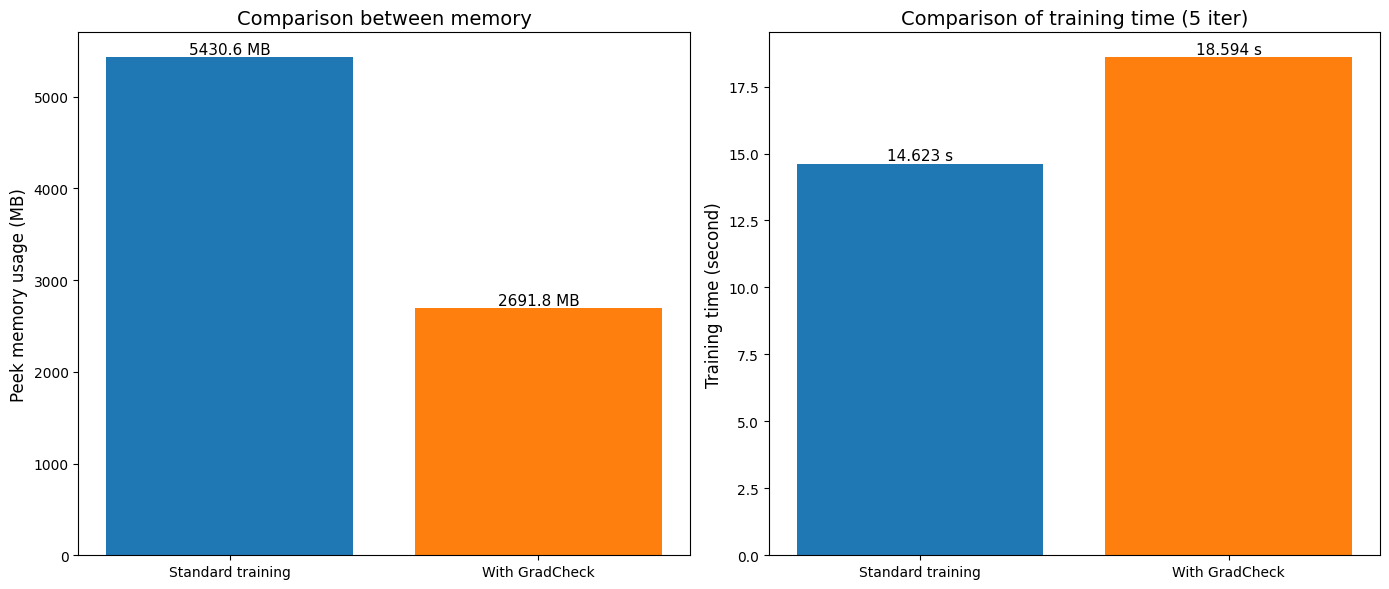

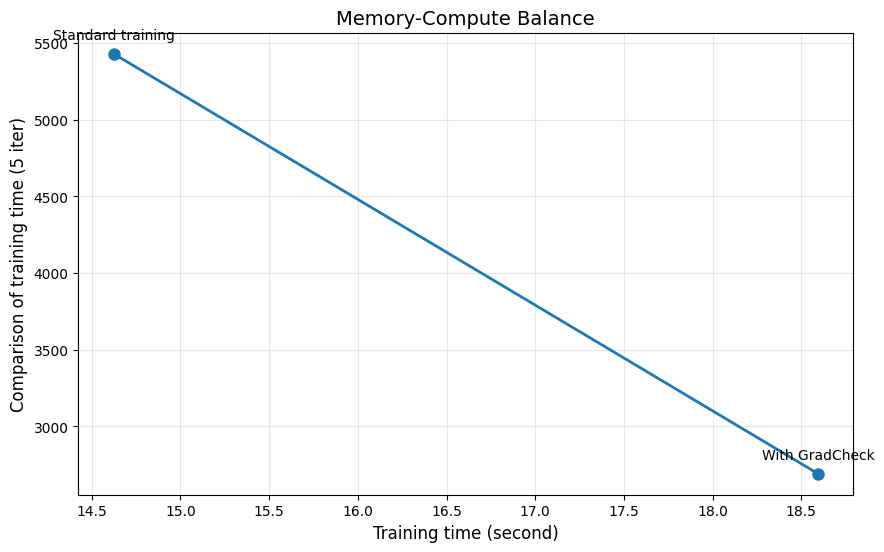

In [8]:
# 结果可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 内存使用对比
memory_data = [standard_memory_peak, checkpoint_memory_peak]
labels = ['Standard training', 'With GradCheck']
colors = ['#1f77b4', '#ff7f0e']
bars = ax1.bar(labels, memory_data, color=colors)
ax1.set_ylabel('Peek memory usage (MB)', fontsize=12)
ax1.set_title('Comparison between memory', fontsize=14)

# 在柱状图上添加数值标签
for bar, value in zip(bars, memory_data):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{value:.1f} MB', ha='center', va='bottom', fontsize=11)

# 训练时间对比
time_data = [standard_duration, checkpoint_duration]
bars = ax2.bar(labels, time_data, color=colors)
ax2.set_ylabel('Training time (second)', fontsize=12)
ax2.set_title('Comparison of training time (5 iter)', fontsize=14)

# 在柱状图上添加数值标签
for bar, value in zip(bars, time_data):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f} s', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# 绘制内存-计算权衡图
plt.figure(figsize=(10, 6))
plt.plot(time_data, memory_data, 'o-', linewidth=2, markersize=8)
plt.xlabel('Training time (second)', fontsize=12)
plt.ylabel('Comparison of training time (5 iter)', fontsize=12)
plt.title('Memory-Compute Balance', fontsize=14)
for i, label in enumerate(labels):
    plt.annotate(label, (time_data[i], memory_data[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.grid(True, alpha=0.3)
plt.show()

##### 5. 总结与思考

从实验结果可以看出，梯度检查点技术显著减少了内存使用，但付出了计算时间增加的代价。这种内存-计算权衡（Memory-Computation Trade-off）是深度学习中常见的优化策略。

梯度检查点的核心价值在于：**它使我们能够训练更深的网络或使用更大的批次大小，而这些在原本的内存限制下是不可能的**。虽然计算时间增加了，但内存使用减少了，这对于内存受限的环境非常有价值。

通过本实验，我们深入理解了梯度检查点技术的原理和实现，并亲身体验了深度学习中的内存-计算权衡关系。这种优化技术是现代深度学习框架中不可或缺的一部分，对于高效训练大型模型至关重要。